In [319]:
import os
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

# Time series decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

# Chart drawing
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Mute sklearn warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

# Show charts when running kernel
init_notebook_mode(connected=True)

# Change default background color for all visualizations
layout=go.Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(250,250,250,0.8)')
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'

In [320]:
# Split data into training/validation and test sets based on dates
train_val_start_date = '2000-01-31'
test_start_date = '2018-08-31'
test_end_date = '2020-08-31'

In [321]:
stock_name = 'XRM'
file_path_1 = '/Users/edocampione/Desktop/Meng Engineering Science/4YP/data/ExxonMobil_CRSP_daily_data_alltime.csv' # Daily technical data (CRSP)

df = pd.read_csv(file_path_1)

df['date'] = pd.to_datetime(df['date'])  # CRSP daily data
df = df[(df['date'] >= train_val_start_date) & (df['date'] <= test_end_date)].copy()
df.index = range(len(df))

df.head()

PERMNO       date TICKER    BIDLO    ASKHI      PRC        VOL        RET  \
0   11850 2000-01-31    XOM  77.8750  83.5625  83.4375  7204601.0   0.057845   
1   11850 2000-02-01    XOM  81.3750  83.4375  83.1875  5332699.0  -0.002996   
2   11850 2000-02-02    XOM  83.2500  84.8750  83.8125  5781399.0   0.007513   
3   11850 2000-02-03    XOM  80.0625  84.0000  82.3750  5805399.0  -0.017151   
4   11850 2000-02-04    XOM  80.0625  83.5000  80.8750  5718099.0  -0.018209   

   OPENPRC  
0  78.6250  
1  83.3125  
2  83.2500  
3  83.4375  
4  83.5000

In [322]:
fig = make_subplots(rows=2, cols=1)

fig.add_trace(go.Ohlc(x=df.date,
                      open=df.OPENPRC,
                      high=df.ASKHI,
                      low=df.BIDLO,
                      close=df.PRC,
                      name='Price'), row=1, col=1)

fig.add_trace(go.Scatter(x=df.date, y=df.VOL, name='Volume'), row=2, col=1)

fig.update(layout_xaxis_rangeslider_visible=False)
fig.show()

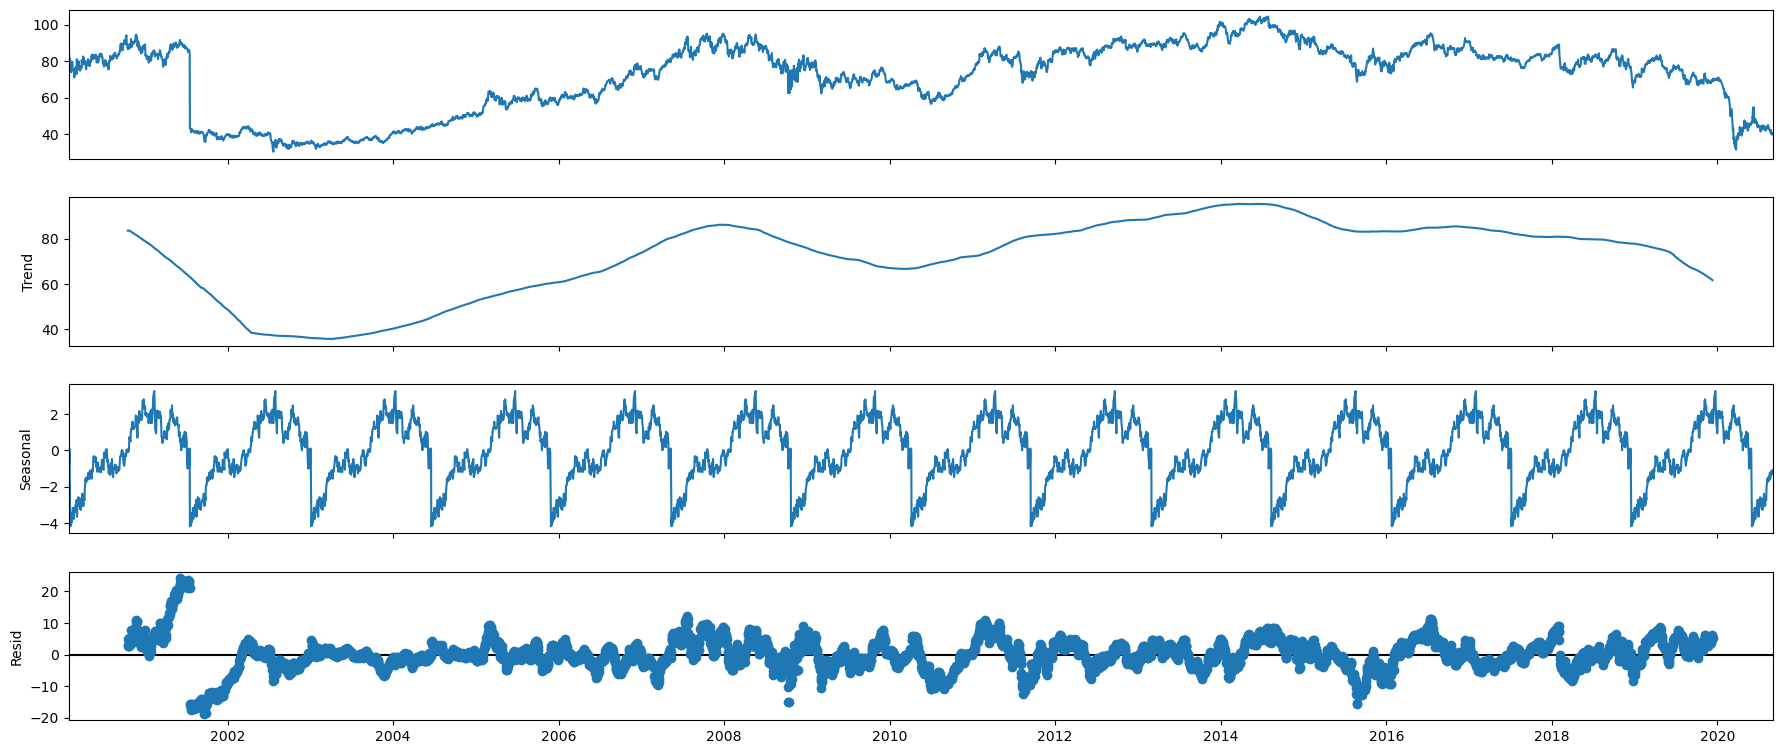

In [323]:
df_close = df[['date', 'PRC']].copy()
df_close = df_close.set_index('date')
df_close.head()

decomp = seasonal_decompose(df_close, period=365)
fig = decomp.plot()
fig.set_size_inches(20, 8)

In [324]:
df['EMA_9'] = df['PRC'].ewm(9).mean().shift()
df['SMA_5'] = df['PRC'].rolling(5).mean().shift()
df['SMA_10'] = df['PRC'].rolling(10).mean().shift()
df['SMA_15'] = df['PRC'].rolling(15).mean().shift()
df['SMA_30'] = df['PRC'].rolling(30).mean().shift()

fig = go.Figure()
fig.add_trace(go.Scatter(x=df.date, y=df.EMA_9, name='EMA 9'))
fig.add_trace(go.Scatter(x=df.date, y=df.SMA_5, name='SMA 5'))
fig.add_trace(go.Scatter(x=df.date, y=df.SMA_10, name='SMA 10'))
fig.add_trace(go.Scatter(x=df.date, y=df.SMA_15, name='SMA 15'))
fig.add_trace(go.Scatter(x=df.date, y=df.SMA_30, name='SMA 30'))
fig.add_trace(go.Scatter(x=df.date, y=df.PRC, name='PRC', opacity=0.2))
fig.show()


In [325]:
def relative_strength_idx(df, n=14):
    close = df['PRC']
    delta = close.diff()
    delta = delta[1:]
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

df['RSI'] = relative_strength_idx(df).fillna(0)

fig = go.Figure(go.Scatter(x=df.date, y=df.RSI, name='RSI'))
fig.show()

In [326]:
EMA_12 = pd.Series(df['PRC'].ewm(span=12, min_periods=12).mean())
EMA_26 = pd.Series(df['PRC'].ewm(span=26, min_periods=26).mean())
df['MACD'] = pd.Series(EMA_12 - EMA_26)
df['MACD_signal'] = pd.Series(df.MACD.ewm(span=9, min_periods=9).mean())

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=df.date, y=df.PRC, name='PRC'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.date, y=EMA_12, name='EMA 12'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.date, y=EMA_26, name='EMA 26'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.date, y=df['MACD'], name='MACD'), row=2, col=1)
fig.add_trace(go.Scatter(x=df.date, y=df['MACD_signal'], name='Signal line'), row=2, col=1)
fig.show()

In [369]:
horizon = 30

df['log_return'] = np.log(df['PRC'].shift(-1*horizon)) - np.log(df['PRC'])  # Compute log returns
df = df.dropna()  # Remove NaNs
df.index = range(len(df))

df.head()

PERMNO       date TICKER    BIDLO    ASKHI      PRC        VOL        RET  \
0   11850 2000-03-17    XOM  77.0000  79.6875  77.1250  7464599.0  -0.032915   
1   11850 2000-03-20    XOM  74.3125  77.3125  74.8750  5342799.0  -0.029173   
2   11850 2000-03-21    XOM  75.6250  77.7500  77.0000  5440299.0   0.028381   
3   11850 2000-03-22    XOM  74.4375  77.0000  74.9375  7126599.0  -0.026786   
4   11850 2000-03-23    XOM  74.3125  76.0625  75.5000  5057799.0   0.007506   

   OPENPRC      EMA_9    SMA_5    SMA_10     SMA_15     SMA_30        RSI  \
0  79.3125  77.270724  77.5250  77.73125  76.658333  76.992188  56.444444   
1  76.1875  77.255735  77.5500  77.87500  77.062500  76.817188  49.234136   
2  75.7500  77.011549  77.3500  78.06875  77.154167  76.617188  51.565762   
3  77.0000  77.010367  77.3000  77.66875  77.266667  76.492188  47.316103   
4  74.6250  76.798791  76.7375  77.20000  77.191667  76.358854  49.698189   

       MACD  MACD_signal  log_return  
0  0.268053     0.173863    0.011281  
1  0.052601     0.146693    0.044089  
2  0.043265     0.124064    0.002432  
3 -0.120320     0.071580    0.059103  
4 -0.204283     0.013198    0.057894

In [370]:
test_size  = 0.15
valid_size = 0.15

test_split_idx  = int(df.shape[0] * (1-test_size))
valid_split_idx = int(df.shape[0] * (1-(valid_size+test_size)))

train_df  = df.loc[:valid_split_idx].copy()
valid_df  = df.loc[valid_split_idx+1:test_split_idx].copy()
test_df   = df.loc[test_split_idx+1:].copy()

fig = go.Figure()
fig.add_trace(go.Scatter(x=train_df.date, y=train_df.PRC, name='Training'))
fig.add_trace(go.Scatter(x=valid_df.date, y=valid_df.PRC, name='Validation'))
fig.add_trace(go.Scatter(x=test_df.date,  y=test_df.PRC,  name='Test'))
fig.show()

test_prices = test_df['PRC']

In [371]:
drop_cols = ['date', 'VOL', 'BIDLO', 'ASKHI', 'RET', 'OPENPRC', 'TICKER', 'PERMNO','PRC']

train_df = train_df.drop(drop_cols, 1)
valid_df = valid_df.drop(drop_cols, 1)
test_df  = test_df.drop(drop_cols, 1)

In [372]:
y_train = train_df['log_return'].copy()
X_train = train_df.drop(['log_return',], 1)

y_valid = valid_df['log_return'].copy()
X_valid = valid_df.drop(['log_return',], 1)

y_test  = test_df['log_return'].copy()
X_test  = test_df.drop(['log_return',], 1)

X_train.info()
X_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3576 entries, 0 to 3575
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   EMA_9        3576 non-null   float64
 1   SMA_5        3576 non-null   float64
 2   SMA_10       3576 non-null   float64
 3   SMA_15       3576 non-null   float64
 4   SMA_30       3576 non-null   float64
 5   RSI          3576 non-null   float64
 6   MACD         3576 non-null   float64
 7   MACD_signal  3576 non-null   float64
dtypes: float64(8)
memory usage: 223.6 KB


EMA_9    SMA_5    SMA_10     SMA_15     SMA_30        RSI      MACD  \
0  77.270724  77.5250  77.73125  76.658333  76.992188  56.444444  0.268053   
1  77.255735  77.5500  77.87500  77.062500  76.817188  49.234136  0.052601   
2  77.011549  77.3500  78.06875  77.154167  76.617188  51.565762  0.043265   
3  77.010367  77.3000  77.66875  77.266667  76.492188  47.316103 -0.120320   
4  76.798791  76.7375  77.20000  77.191667  76.358854  49.698189 -0.204283   

   MACD_signal  
0     0.173863  
1     0.146693  
2     0.124064  
3     0.071580  
4     0.013198

In [331]:
%%time

parameters = {
    'n_estimators': [300],
    'learning_rate': [0.05],
    'max_depth': [8],
    'gamma': [0.00001],
    'random_state': [42]
}

eval_set = [(X_train, y_train), (X_valid, y_valid)]
model = xgb.XGBRegressor(eval_set=eval_set, objective='reg:squarederror', verbose=False)
clf = GridSearchCV(model, parameters)

clf.fit(X_train, y_train)

print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')

/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning:

[13:34:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "eval_set", "verbose" } are not used.


/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning:

[13:34:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "eval_set", "verbose" } are not used.


/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning:

[13:34:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "eval_set", "verbose" } are not used.


/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning:

[13:34:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "eval_set", "verbose" } are not used.


/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning:

[13:34:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { 

Best params: {'gamma': 1e-05, 'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 300, 'random_state': 42}
Best validation score = -0.9548090119974624
CPU times: user 32.5 s, sys: 2.1 s, total: 34.6 s
Wall time: 6.28 s


In [373]:
%%time

model = xgb.XGBRegressor(**clf.best_params_, objective='reg:squarederror')
model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

CPU times: user 7.4 s, sys: 558 ms, total: 7.96 s
Wall time: 1.46 s


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=1e-05, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

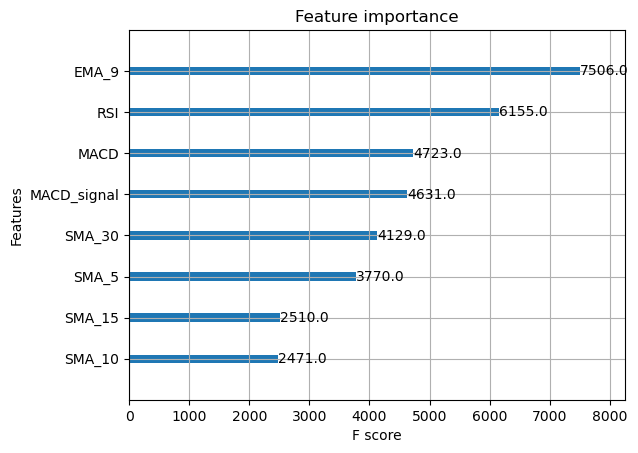

In [374]:
plot_importance(model);

In [375]:
y_pred = model.predict(X_test)

print(f'y_true = {np.array(y_test)[:5]}')
print(f'y_pred = {y_pred[:5]}')

test_df.head()

# Convert predicted log returns to prices
y_pred_price = test_prices.values * np.exp(y_pred)  # Apply transformation
y_test_price = test_prices.values * np.exp(y_test)

print(f'y_true_price = {np.array(y_test_price)[:5]}')
print(f'y_pred_price = {y_pred_price[:5]}')

y_true = [-0.0117336  -0.01078813 -0.01792717 -0.01588123 -0.01115806]
y_pred = [0.01178173 0.03530265 0.03436955 0.02492583 0.02425347]
y_true_price = [80.49 80.21 80.16 79.96 80.21]
y_pred_price = [82.40518045 83.99346841 84.46365243 83.2904253  83.10124734]


In [376]:
print(f'mean_squared_error = {mean_squared_error(y_test_price, y_pred_price)}')

correct_signs = np.sign(y_test) == np.sign(y_pred)
percentage_correct_signs = np.mean(correct_signs) * 100

print(f"Percentage of Correct Sign Predictions: {percentage_correct_signs:.2f}%")

mean_squared_error = 53.98569251476355
Percentage of Correct Sign Predictions: 50.91%


In [383]:
predicted_prices = df.loc[test_split_idx+1:].copy()
predicted_prices['predPRC'] = y_pred_price
predicted_prices['predPRC'] = predicted_prices['predPRC'].shift(-1*horizon)

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=df.date, y=df.PRC,
                         name='Truth',
                         marker_color='LightSkyBlue'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.date,
                         y=predicted_prices.predPRC,
                         name='Prediction',
                         marker_color='MediumPurple'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.date,
                         y=y_test_price,
                         name='Truth',
                         marker_color='LightSkyBlue',
                         showlegend=False), row=2, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.date,
                         y=predicted_prices.predPRC,
                         name='Prediction',
                         marker_color='MediumPurple',
                         showlegend=False), row=2, col=1)

fig.show()

predicted_prices.tail()

PERMNO       date TICKER  BIDLO   ASKHI    PRC         VOL        RET  \
5103   11850 2020-06-30    XOM  43.16  44.970  44.72  22153616.0   0.009025   
5104   11850 2020-07-01    XOM  43.67  45.380  43.71  17290059.0  -0.022585   
5105   11850 2020-07-02    XOM  43.93  45.185  44.08  18216593.0   0.008465   
5106   11850 2020-07-06    XOM  43.84  45.080  44.39  22692048.0   0.007033   
5107   11850 2020-07-07    XOM  43.11  44.000  43.24  17407625.0  -0.025907   

      OPENPRC      EMA_9   SMA_5  SMA_10     SMA_15     SMA_30        RSI  \
5103    43.43  46.313996  44.862  45.846  46.874667  46.978000  30.981398   
5104    44.49  46.154596  44.466  45.498  46.288000  46.957333  39.818631   
5105    44.62  45.910137  44.308  45.206  45.825333  46.949667  36.576890   
5106    44.67  45.727123  44.090  44.922  45.685333  46.906667  38.337574   
5107    43.90  45.593411  44.244  44.763  45.500000  46.901000  29.124579   

          MACD  MACD_signal  log_return  predPRC  
5103 -0.506349     0.055286   -0.014188      NaN  
5104 -0.629083    -0.081588   -0.016144      NaN  
5105 -0.688557    -0.202981   -0.020166      NaN  
5106 -0.702578    -0.302901   -0.040221      NaN  
5107 -0.797294    -0.401779   -0.018910      NaN